In [2]:
import os

from math import ceil, floor

import copy

import pickle

import numpy as np

from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets.vision import VisionDataset

from tqdm import tqdm

from sklearn.manifold import TSNE

from datasets import BadNetsDataset, WaNetDataset, SIGDataset
from simclr import SimClrBackbone

In [3]:
device = "cuda"

### Poison dataset

In [4]:
def prepare_poison_dataset(dataset_name: str, train: bool, dataset_root: str = 'C:/Datasets', download: bool = False) -> VisionDataset:
    clean_dataset = torchvision.datasets.CIFAR10(root=dataset_root, train=train, download=download)

    if dataset_name == "badnets":
        poison_dataset = BadNetsDataset(clean_dataset, 1, "triggers/trigger_10.png", seed=1)
    elif dataset_name == "wanet":
        poison_dataset = WaNetDataset(clean_dataset, 0, seed=1)
    elif dataset_name == "sig":
        poison_dataset = SIGDataset(clean_dataset, 1, 20, 6, seed=1)
    elif dataset_name == "sig2":
        poison_dataset = SIGDataset(clean_dataset, 2, 20, 6, seed=2)
    else:
        raise Exception("Invalid dataset")

    poison_indices = np.array([poison_dataset.is_poison(i) for i in range(len(poison_dataset))])

    return poison_dataset, poison_indices

### Load SimCLR model

In [5]:
def load_simclr(simclr_model_name: str) -> SimClrBackbone:
    model = SimClrBackbone()
    out = os.path.join('./saved_models/', simclr_model_name)
    checkpoint = torch.load(out, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    model = model.to(device)
    model.eval()
    return model

### Extract SimCLR features for all images

In [6]:
def extract_simclr_features(model: SimClrBackbone, dataset: VisionDataset):

    simclr_feature_size = 128
    num_examples = len(dataset)

    features = np.zeros((num_examples, simclr_feature_size))
    labels_poison = np.zeros((num_examples))
    labels_true = np.zeros((num_examples))

    batch_size = 256
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    for i, (img, labels_batch_poison, labels_batch_true) in enumerate(dataloader):

        with torch.no_grad():
            features_batch = model(img.to(device)).cpu().data.numpy()
            
        features[i*batch_size : i*batch_size+len(features_batch)] = features_batch
        labels_poison[i*batch_size : i*batch_size+len(labels_batch_poison)] = labels_batch_poison.long()
        labels_true[i*batch_size : i*batch_size+len(labels_batch_true)] = labels_batch_true.long()

    labels_poison = labels_poison.astype(int)
    labels_true = labels_true.astype(int)

    return features, labels_poison, labels_true

### Plot t-SNE features

In [7]:
import umap

def calculate_tsne_features(features: np.array, perplexity: int = 50) -> np.array:
    tsne = TSNE(n_components = 2, perplexity = perplexity)
    tsne_features = tsne.fit_transform(features)
    
    #tsne = umap.UMAP(n_neighbors=perplexity)
    #tsne_features = tsne.fit_transform(features)

    return tsne_features

def plot_tsne_features(tsne_features: np.array, labels: np.array, poison_indices: np.array, legend: bool = True) -> None:
    num_classes = int(max(labels).item())

    # label poison examples as 10
    labels_10 = copy.deepcopy(labels)
    labels_10[poison_indices] = 10

    for i in range(num_classes):
        plt.scatter(tsne_features[labels_10==i,1], tsne_features[labels_10==i,0])
    plt.scatter(tsne_features[labels_10==10,1], tsne_features[labels_10==10,0], c = "black", marker= "x")

    if legend:
        plt.legend([str(i) for i in range(num_classes)] + ["poison"])
    plt.show()


def calculate_and_plot_tsne(features: np.array, labels: np.array, poison_indices: np.array, subset_size: int = None, legend: bool = True) -> np.array:
    # Plot only a subset
    if subset_size is None:
        subset_size = len(features)
    features_subset = features[:subset_size]
    labels_subset = labels[:subset_size]
    poison_indices_subset = poison_indices[:subset_size]
    
    tsne_features = calculate_tsne_features(features_subset)
    plot_tsne_features(tsne_features, labels_subset, poison_indices_subset, legend=legend)
    


c:\Users\Luka\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Util functions for all cleanses

In [8]:
def evaluate_cleanse(poison_predicted: np.array, poison_indices: np.array, verbose: bool = True) -> float:

    tp = (poison_indices & poison_predicted).sum()
    fp = (np.invert(poison_indices) & poison_predicted).sum()
    fn = (poison_indices & np.invert(poison_predicted)).sum()
    tn = (np.invert(poison_indices) & np.invert(poison_predicted)).sum()

    fnr = fn/(fn+tp) if fn+tp!=0 else 0
    tnr = tn/(tn+fp) if tn+fp!=0 else 0
    poison_rate = fn/(fn+tn) if fn+tn!=0 else 0

    if verbose:
        print(f"{tp} \t {fp}")
        print(f"{fn} \t {tn}")
        print(f"Percentage of poisoned images (out of all poisoned) kept: {100*fnr: .2f}%")
        print(f"Percentage of clean images (out of all clean) kept: {100*tnr: .2f}%")
        print(f"Percentage of remaining poisoned images (out of all remaining): {100*poison_rate: .2f}%")

    return poison_rate

In [9]:
def save_predicted_indices(predicted_indices: np.array, save_name: str):
    with open(f"./cleansed_labels/{save_name}.pkl", "wb") as f:
        pickle.dump(predicted_indices, f)

In [10]:
def plot_histogram_poisoned(values: np.array, poison_indices: np.array = None, is_integer: bool = False, bins_num: int = 100, separation_line: float = None) -> None:
    if poison_indices is not None:
        values_clean = values[np.invert(poison_indices)]
        values_poisoned = values[poison_indices]
    else:
        values_clean = values[:]
        values_poisoned = []

    bins = np.linspace(floor(np.min(values)), ceil(np.max(values)), int(np.max(values)) if is_integer else bins_num)
    plt.hist(values_clean, bins, alpha=0.5, label='clean')
    plt.hist(values_poisoned, bins, alpha=0.5, label='poisoned')

    if separation_line:
        plt.axvline(separation_line, color='red', linestyle='dashed', linewidth=1)

    plt.legend(loc='upper right')
    plt.show()

## Step 1: Non-disruptive cleanse

### kNN

In [11]:
from sklearn.neighbors import KNeighborsClassifier

def knn_cleanse(features: np.array, labels_poison: np.array, num_classes: int, n_neighbors: int = None) -> np.array:
    
    if n_neighbors is None:
        examples_per_class = len(features) / num_classes
        n_neighbors=int(examples_per_class/2)
        
    knn = KNeighborsClassifier(n_neighbors)
    knn.fit(features, labels_poison)
    labels_predicted = knn.predict(features)

    return labels_predicted != labels_poison

------------------------------------

CIFAR-10 train \
BadNets 

    4905 	 9481
    95 	 35519
    Percentage of poisoned images (out of all poisoned) kept:  1.90%
    Percentage of clean images (out of all clean) kept:  78.93%
    Percentage of remaining poisoned images (out of all remaining):  0.27%

CIFAR-10 test \
BadNets 

    960 	 2056
    40 	 6944
    Percentage of poisoned images (out of all poisoned) kept:  4.00%
    Percentage of clean images (out of all clean) kept:  77.16%
    Percentage of remaining poisoned images (out of all remaining):  0.57%

------------------------------------

CIFAR-10 train \
WaNet 

    3975 	 14331
    1025 	 30669
    Percentage of poisoned images (out of all poisoned) kept:  20.50%
    Percentage of clean images (out of all clean) kept:  68.15%
    Percentage of remaining poisoned images (out of all remaining):  3.23%

CIFAR-10 test \
WaNet 

    712 	 3058
    288 	 5942
    Percentage of poisoned images (out of all poisoned) kept:  28.80%
    Percentage of clean images (out of all clean) kept:  66.02%
    Percentage of remaining poisoned images (out of all remaining):  4.62%

------------------------------------

CIFAR-10 train \
SIG

    0 	 9195
    500 	 40305
    Percentage of poisoned images (out of all poisoned) kept:  100.00%
    Percentage of clean images (out of all clean) kept:  81.42%
    Percentage of remaining poisoned images (out of all remaining):  1.23%

CIFAR-10 test \
SIG

    0 	 2179
    100 	 7721
    Percentage of poisoned images (out of all poisoned) kept:  100.00%
    Percentage of clean images (out of all clean) kept:  77.99%
    Percentage of remaining poisoned images (out of all remaining):  1.28%


### Energy

In [12]:
class EnergyClassifier():

    def __init__(self, t=1):
        self.t = t

    def fit(self, X, y):
        self.X = X
        self.y = y
        
        self.C = int(np.max(y))
        self.Ic = {c:[i for i in range(len(y)) if y[i]==c] for c in range(self.C)}
        
    def predict_index(self, i):
        # consider improving with numpy and batch

        xi = self.X[i]

        exp_all = np.exp([xi*self.X[k]/self.t for k in range(len(self.X))])
        sum_exp_all_except_xi = np.sum([exp_all[k] for k in range(len(self.X)) if k!=i])
        mean_exp_c = [np.mean([exp_all[k] for k in self.Ic[c] if k!=i]) for c in range(self.C)]
    
        Scs = mean_exp_c / sum_exp_all_except_xi
        return np.argmax(Scs)

    def predict(self):
        predicted = np.zeros((len(self.X)))
        for i in tqdm(range(len(self.X))):
            predicted[i] = self.predict_index(i)
        return predicted

In [13]:
def energy_cleanse(features: np.array, labels_poison: np.array, t: float = 10) -> np.array:
    
    # if DATASET == "badnets":
    #     T = 100
    # elif DATASET == "wanet":
    #     T = 10
    # elif DATASET == "sig":
    #     T = 1
    # else:
    #     raise Exception("Invalid dataset")

    energy = EnergyClassifier(t=t)
    energy.fit(features, labels_poison)
    labels_predicted = energy.predict()

    return labels_predicted != labels_poison

# if RUN_ENERGY:
#     labels_predicted_energy = energy_cleanse(features, labels_poison)
#     evaluate_cleanse(labels_predicted_energy != labels_poison, poison_indices)

#     save_name = f"__NEW__{DATASET_NAME}-Energy-{'train' if TRAIN else 'test'}"
#     save_predicted_labels(labels_predicted_knn, save_name)

CIFAR-10 train \
BadNets

	50000 / 50000
		4618 	 12732
		382 	 32268
	Percentage of poisoned images (out of all poisoned) kept:  7.64%
	Percentage of clean images (out of all clean) kept:  71.71%
	Percentage of remaining poisoned images (out of all remaining):  1.17%

CIFAR-10 test \
BadNets

	10000 / 10000
		920 	 2585
		80 	 6415
	Percentage of poisoned images (out of all poisoned) kept:  8.00%
	Percentage of clean images (out of all clean) kept:  71.28%
	Percentage of remaining poisoned images (out of all remaining):  1.23%

--------------------------------------------------------------------------------

CIFAR-10 train \
WaNet

	50000 / 50000
		4725 	 14096
		275 	 30904
	Percentage of poisoned images (out of all poisoned) kept:  5.50%
	Percentage of clean images (out of all clean) kept:  68.68%
	Percentage of remaining poisoned images (out of all remaining):  0.88%

CIFAR-10 test \
WaNet

	10000 / 10000
		951 	 2851
		49 	 6149
	Percentage of poisoned images (out of all poisoned) kept:  4.90%
	Percentage of clean images (out of all clean) kept:  68.32%
	Percentage of remaining poisoned images (out of all remaining):  0.79%

--------------------------------------------------------------------------------

CIFAR-10 train \
SIG

	50000 / 50000
		2 	 15777
		498 	 33723
	Percentage of poisoned images (out of all poisoned) kept:  99.60%
	Percentage of clean images (out of all clean) kept:  68.13%
	Percentage of remaining poisoned images (out of all remaining):  1.46%

### LogReg 

In [14]:
# TODO cleanup, delete?

In [15]:
class LogReg(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(LogReg, self).__init__()
        self.linear = torch.nn.Linear(n_inputs, n_outputs)
    def forward(self, x):
        return torch.softmax(self.linear(x), dim=1)

In [16]:
class SimClrFeaturesDataset(VisionDataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    def __getitem__(self, index):
        return self.features[index], self.labels[index]
    def __len__(self):
        return len(self.features)

In [17]:
# if RUN_LOGREG:
    
#     BATCH_SIZE = 1024
#     NUM_MODELS = 10
#     EPOCHS = 60

#     classifications = np.zeros((NUM_MODELS, len(features)))

#     for num_model in range(NUM_MODELS):
#         print(f"Learning logistic regression model {num_model+1}/{NUM_MODELS}")
#         simclr_features_dataset = SimClrFeaturesDataset(features, labels_poison)
#         dataloader = DataLoader(dataset=simclr_features_dataset, batch_size=BATCH_SIZE, shuffle=True) 
#         model = LogReg(128, 10)
#         optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-1)
#         criterion = torch.nn.CrossEntropyLoss()
        
#         # train
#         for epoch in range(EPOCHS):
#             correct = 0
#             for i, (batch_features, batch_labels) in enumerate(dataloader):
#                 batch_features, batch_labels = batch_features.float(), batch_labels.long()

#                 optimizer.zero_grad()
#                 outputs = model(batch_features)
#                 loss = criterion(outputs, batch_labels)
#                 loss.backward()
#                 optimizer.step()
#                 _, predicted = torch.max(outputs.data, 1)
#                 correct += (predicted == batch_labels).sum()
#             accuracy = 100 * (correct.item()) / len(simclr_features_dataset)
#         print(f"Accuracy: {accuracy}")

#         # get model classifications
#         dataloader = DataLoader(dataset=simclr_features_dataset, batch_size=BATCH_SIZE, shuffle=False) 
#         for i, (batch_features, batch_labels) in enumerate(dataloader):
#             batch_features, batch_labels = batch_features.float(), batch_labels.long()

#             outputs = model(batch_features)
#             _, predicted = torch.max(outputs.data, 1)
#             predicted = predicted.numpy()
#             classifications[num_model, (i*BATCH_SIZE):(i*BATCH_SIZE+len(predicted))] = predicted


In [18]:
# if RUN_LOGREG:

#     labels_poison_repeated = np.tile(labels_poison, (NUM_MODELS,1))
#     misclassifications = np.sum(classifications != labels_poison_repeated, axis=0)

#     misclassifications_poisoned = misclassifications[poison_indices]
#     misclassifications_clean = misclassifications[np.invert(poison_indices)]

#     # print(misclassifications_poisoned.shape)
#     # print(misclassifications_clean.shape)

#     # print(np.average(misclassifications_poisoned))
#     # print(np.average(misclassifications_clean))

#     bins = np.linspace(0, np.max(misclassifications), np.max(misclassifications))
#     plt.hist(misclassifications_clean, bins, alpha=0.5, label='clean')
#     plt.hist(misclassifications_poisoned, bins, alpha=0.5, label='poisoned')
#     plt.legend(loc='upper right')
#     plt.show()

In [19]:
# if RUN_LOGREG:

#     class_num = 1

#     misclassifications_class = misclassifications[labels_poison == class_num]
#     misclassifications_class_poisoned = misclassifications[np.logical_and(labels_poison == class_num, poison_indices)]
#     misclassifications_class_clean = misclassifications[np.logical_and(labels_poison == class_num, np.invert(poison_indices))]

#     print((labels_poison == class_num & np.invert(poison_indices)).shape)
#     print(misclassifications_class.shape)
#     print(misclassifications_class_poisoned.shape)
#     print(misclassifications_class_clean.shape)

#     bins = np.linspace(0, np.max(misclassifications_class), np.max(misclassifications_class))
#     plt.hist(misclassifications_class_clean, bins, alpha=0.5, label='clean')
#     plt.hist(misclassifications_class_poisoned, bins, alpha=0.5, label='poisoned')
#     plt.legend(loc='upper right')
#     plt.show()

## Disruptive detection

### Centroid

In [20]:
def centroid_cleanse(features: np.array, poison_indices: np.array) -> np.array:
    centroid = np.sum(features, axis=0) / features.shape[0]
    distances = np.linalg.norm(features - centroid, axis=1)
    
    plot_histogram_poisoned(distances, poison_indices)

### Gauss 

In [21]:
from scipy.stats import multivariate_normal

def gauss_cleanse(features: np.array, discard_percentage: float, poison_indices: np.array = None) -> np.array:
    mean = np.mean(features, axis=0)
    cov = np.cov(features, rowvar=0)

    probabilities = multivariate_normal.pdf(features, mean=mean, cov=cov, allow_singular=True)
    probabilities[probabilities <= 0] = 1e-100
    probabilities = -np.log(probabilities)

    discard_line = np.percentile(probabilities, (1-discard_percentage)*100)
    plot_histogram_poisoned(probabilities, poison_indices, separation_line=discard_line)

    predicted_poison_indices = probabilities > discard_line
    return predicted_poison_indices

In [22]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import euclidean

def kmeans_cleanse(features: np.array, means: int = 50) -> np.array:
	kmeans = KMeans(n_clusters=means, init="k-means++")
	kmeans.fit(features)
	
	centroid = np.mean(features, axis=0)
	cluster_center_distances = [euclidean(center, centroid) for center in kmeans.cluster_centers_]
	poison_cluster_index = cluster_center_distances.index(max(cluster_center_distances))

	predicted_poison_indices = kmeans.predict(features) == poison_cluster_index
	return predicted_poison_indices

In [23]:
def kmeans_cleanse_smallest(features: np.array, means: int = 50) -> np.array:
	kmeans = KMeans(n_clusters=means, init="k-means++")
	kmeans.fit(features)
	
	predicted_cluster = kmeans.predict(features)
	
	values, counts = np.unique(predicted_cluster, return_counts=True)
	#print([x for x in zip(values, counts)])
	predicted_poison_cluster_index = np.argmin(counts)
	#print(predicted_poison_cluster_index)

	# just for debug
	#actual_poison_cluster_predictions = kmeans.predict(features[true_poison_indices])
	#print(actual_poison_cluster_predictions)

	predicted_poison_indices = predicted_cluster == predicted_poison_cluster_index
	return predicted_poison_indices

## Poison reclassification

### Weak binary classifier 

In [24]:
class PoisonClassificationDataset(VisionDataset):

    def __init__(self, original_dataset: VisionDataset, poison_indices: np.array) -> None:
        self.original_dataset = original_dataset
        self.poison_indices = poison_indices

    def __len__(self) -> int:
        return len(self.original_dataset)
    
    def __getitem__(self, index: int):
        return self.original_dataset[index][0], torch.tensor(self.poison_indices[index])

In [25]:
import torch.nn as nn
from torch.utils.data import WeightedRandomSampler

class ConvolutionalBinaryClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2, bias=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2, bias=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Flatten(),
            nn.Linear(1568, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x) -> torch.tensor:
        return self.layers(x)

def train_binary_classifier(dataset: VisionDataset, predicted_poison_indices: np.array) -> nn.Module:
    poison_classification_dataset = PoisonClassificationDataset(dataset, predicted_poison_indices)
    # sampler for class imbalance
    positives = sum([1 for _, target in poison_classification_dataset if target==1])
    total = len(poison_classification_dataset)
    positive_weight = 0.5 / positives
    negative_weight = 0.5 / (total - positives)
    weights = [positive_weight if target==1 else negative_weight for _, target in poison_classification_dataset]
    sampler = WeightedRandomSampler(weights, len(weights))

    dataloader = DataLoader(poison_classification_dataset, batch_size=128, sampler=sampler)
    model = ConvolutionalBinaryClassifier().to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1-1e-4)
    num_epochs = 10

    for _ in tqdm(range(num_epochs)):
        for _, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(device), targets.to(device).float()
            optimizer.zero_grad()
            logits = model.forward(inputs).squeeze(-1)
            loss = criterion(logits, targets)
            loss.backward()
            optimizer.step()
        scheduler.step()

    return model

def binary_reclassification(dataset: VisionDataset, model: nn.Module):
    predicted_poison_indices = np.zeros((len(dataset)))
    batch_size = 128
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    for i, (inputs, _, _) in enumerate(dataloader):
        inputs = inputs.to(device)
        with torch.no_grad():
            logits = model.forward(inputs).squeeze(-1)
            predictions = (logits>0.5).cpu().numpy()
        predicted_poison_indices[i*batch_size : i*batch_size+len(predictions)] = predictions
    return predicted_poison_indices==1
        


### Strong multiclass classifier

In [26]:
from torchvision import transforms

class CleansedDataset(VisionDataset):

    def __init__(self, poison_dataset: VisionDataset, predicted_poison: np.array, transforms: torch.nn.Module = None):
        self.data = [poison_dataset[i][0] for i in range(len(poison_dataset)) if not predicted_poison[i]]
        self.labels = [poison_dataset[i][1] for i in range(len(poison_dataset)) if not predicted_poison[i]]
        self.transforms = transforms

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data[index]
        label = self.labels[index]

        if self.transforms:
            item = self.transforms(item)

        return item, label

In [27]:
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [28]:
def train_multiclass_classifier(dataset: VisionDataset, predicted_poison_indices: np.array) -> nn.Module:
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

    cleansed_dataset = CleansedDataset(dataset, predicted_poison_indices, transform_train)
    dataloader = DataLoader(cleansed_dataset, batch_size=128, shuffle=True, num_workers=0)

    model = ResNet18()
    model.to(device)

    epochs = 35
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

    model.train()
    for epoch in tqdm(range(epochs)):
        train_loss = 0
        correct = 0
        total = 0
        for _, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        acc = 100.*correct/total
        scheduler.step()
        print(epoch, train_loss, acc)
    model.eval()
    return model

In [29]:
def multiclass_reclassification(dataset: VisionDataset, model: nn.Module, true_labels: np.array):
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])
    
    transform_dataset = CleansedDataset(dataset, np.zeros(len(dataset)), transform_train)
    
    predicted_labels = np.zeros((len(dataset)))
    batch_size = 128
    dataloader = DataLoader(transform_dataset, batch_size=batch_size, shuffle=False)
    for i, (inputs, _) in enumerate(dataloader):
        inputs = inputs.to(device)
        with torch.no_grad():
            logits = model.forward(inputs)
            predictions = torch.argmax(logits, 1).cpu().numpy()
        predicted_labels[i*batch_size : i*batch_size+len(predictions)] = predictions
    return predicted_labels!=true_labels

# Final cleanse pipeline

In [50]:
device = "cuda"

dataset_name = "sig2"

train = True
simclr_model_name = f"{dataset_name}-SimCLR.pt"

dataset, true_poison_indices = prepare_poison_dataset(dataset_name, train, download=True)
simclr = load_simclr(simclr_model_name)
features, labels_poison, labels_true = extract_simclr_features(simclr, dataset)
num_classes = int(max(labels_poison).item())

Files already downloaded and verified


c:\Users\Luka\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Luka\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [51]:
# Hiperparameters

tsne_perplexity = len(dataset) / 100
gauss_discard = 0.005

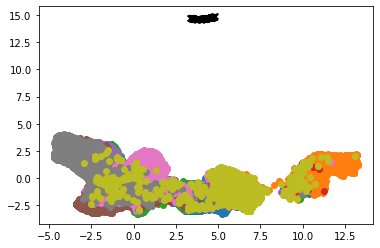

In [52]:
tsne_features = calculate_tsne_features(features, perplexity=tsne_perplexity)
plot_tsne_features(tsne_features, labels_poison, true_poison_indices, legend=False)

In [53]:
# TESTING
count = 0
total = 50
for current in range(1,total+1):
    predicted_poison_indices_disruptive = kmeans_cleanse_smallest(tsne_features, means=11)
    pr = evaluate_cleanse(predicted_poison_indices_disruptive, true_poison_indices, verbose=False)
    if pr==0:
        count+=1
    print(f"{pr} - {count}/{current}")

0.0 - 1/1
0.0 - 2/2
0.0 - 3/3
0.0 - 4/4
0.0 - 5/5
0.0 - 6/6
0.0 - 7/7
0.0 - 8/8
0.0 - 9/9
0.0 - 10/10
0.0 - 11/11
0.0 - 12/12
0.0 - 13/13
0.0 - 14/14
0.0 - 15/15
0.0 - 16/16
0.0 - 17/17
0.0 - 18/18
0.0 - 19/19
0.0 - 20/20
0.0 - 21/21
0.0 - 22/22
0.0 - 23/23
0.0 - 24/24
0.0 - 25/25
0.0 - 26/26
0.0 - 27/27
0.0 - 28/28
0.0 - 29/29
0.0 - 30/30
0.0 - 31/31
0.0 - 32/32
0.0 - 33/33
0.0 - 34/34
0.0 - 35/35
0.0 - 36/36
0.0 - 37/37
0.0 - 38/38
0.0 - 39/39
0.0 - 40/40
0.0 - 41/41
0.0 - 42/42
0.0 - 43/43
0.0 - 44/44
0.0 - 45/45
0.0 - 46/46
0.0 - 47/47
0.0 - 48/48
0.0 - 49/49
0.0 - 50/50


In [65]:
# Nondisruptive cleanse
predicted_poison_indices_nondisruptive = knn_cleanse(features, labels_poison, num_classes, n_neighbors=int(tsne_perplexity))
#predicted_poison_indices_nondisruptive = energy_cleanse(features, labels_poison, t=1)
evaluate_cleanse(predicted_poison_indices_nondisruptive, true_poison_indices)

4810 	 9991
190 	 35009
Percentage of poisoned images (out of all poisoned) kept:  3.80%
Percentage of clean images (out of all clean) kept:  77.80%
Percentage of remaining poisoned images (out of all remaining):  0.54%


0.005397880621608568

In [45]:
# Disruptive cleanse
#predicted_poison_indices_disruptive = gauss_cleanse(tsne_features, gauss_discard, poison_indices=true_poison_indices)
predicted_poison_indices_disruptive = kmeans_cleanse_smallest(tsne_features, means=11)
evaluate_cleanse(predicted_poison_indices_disruptive, true_poison_indices)

500 	 0
0 	 49500
Percentage of poisoned images (out of all poisoned) kept:  0.00%
Percentage of clean images (out of all clean) kept:  100.00%
Percentage of remaining poisoned images (out of all remaining):  0.00%


0.0

In [165]:
# Combine cleanses

predicted_poison_indices_final = predicted_poison_indices_nondisruptive | predicted_poison_indices_disruptive
evaluate_cleanse(predicted_poison_indices_final, true_poison_indices)

NameError: name 'predicted_poison_indices_nondisruptive' is not defined

In [64]:
#poison_multiclass_classifier_model = train_multiclass_classifier(dataset, predicted_poison_indices_final)

In [65]:
#predicted_poison_indices_multiclass_reclassification = multiclass_reclassification(dataset, poison_multiclass_classifier_model, labels_poison)
#evaluate_cleanse(predicted_poison_indices_multiclass_reclassification, true_poison_indices)

In [66]:
# Final cleanse report
print("---------------------------------------")
train_string = "train" if train else "test"
print(f"{dataset_name} {train_string}")
print("\nNon-disruptive cleanse: ")
evaluate_cleanse(predicted_poison_indices_nondisruptive, true_poison_indices)
print("\nDisruptive cleanse: ")
evaluate_cleanse(predicted_poison_indices_disruptive, true_poison_indices)
print("\nCombined cleanse: ")
evaluate_cleanse(predicted_poison_indices_final, true_poison_indices)
#print("\nReclassify (multiclass) combined cleanse: ")
#evaluate_cleanse(predicted_poison_indices_multiclass_reclassification, true_poison_indices)
print("---------------------------------------")

---------------------------------------
sig test

Non-disruptive cleanse: 
51 	 2670
49 	 7230
Percentage of poisoned images (out of all poisoned) kept:  49.00%
Percentage of clean images (out of all clean) kept:  73.03%
Percentage of remaining poisoned images (out of all remaining):  0.67%

Disruptive cleanse: 
0 	 314
100 	 9586
Percentage of poisoned images (out of all poisoned) kept:  100.00%
Percentage of clean images (out of all clean) kept:  96.83%
Percentage of remaining poisoned images (out of all remaining):  1.03%

Combined cleanse: 
51 	 2965
49 	 6935
Percentage of poisoned images (out of all poisoned) kept:  49.00%
Percentage of clean images (out of all clean) kept:  70.05%
Percentage of remaining poisoned images (out of all remaining):  0.70%
---------------------------------------


In [67]:
train_str = "train" if train else "test"
save_name = f"{dataset_name}-(tsne+knn+kmeans)-{train_str}"

save_predicted_indices(predicted_poison_indices_final, save_name)